## James Bay  ANHAlysis 
### Preliminary search for Marine Heatwaves on ANHA4 model data.
###### By Emilio Enriquez -- Apr1

----

Here I summarize the current progress on the search for Marine Heatwave in ANHA4 data. 



Hobday et. al. (2008), categorizes marine heatwaves (MHWs) based on the long term trends of sea surface temperatures (SST). It takes the temperature difference between the mean SST and the 90th percentile SST for a given region ($\Delta T$). Multiples of this difference define Categories I, II, III, and IV. 


We used the Arctic and Northern Hemisphere Atlantic (ANHA) configuration of the NEMO model. In particular the low resolution configuration at 1/4 degree resolution (ANHA4).




In [17]:
# -*- coding: utf-8 -*-


# Data related libraries
import pandas as pd
import datetime
import numpy as np
import netCDF4 as nc

# Plotting related libraries
import matplotlib
# for interactive ploting
%matplotlib nbagg    
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import seaborn as sns

# Project custom made libaries
import anha4_utils as au

# Machine specific libraries
from sys import platform
import glob
import os


In [2]:
# Setting up James Bay location
east = -78.5
west = -82.5
north = 54.7
south = 51

lat_range  = (south,north)
lon_range = (west,east)

# Setting up data specific params
year= '1998'
grid = 'T'
month_list = ['04','06','08']
day_list = [5,4,3]


# Get file list
file_list = au.get_file_list()


This figure shows examples of ANHA4 data for the months of April, June and August in 1998. Here the geographical limits for James Bay are taken arbitrarily as [51,54.7] in Latitude, and [-78.5,-82.5] in Longitude. 


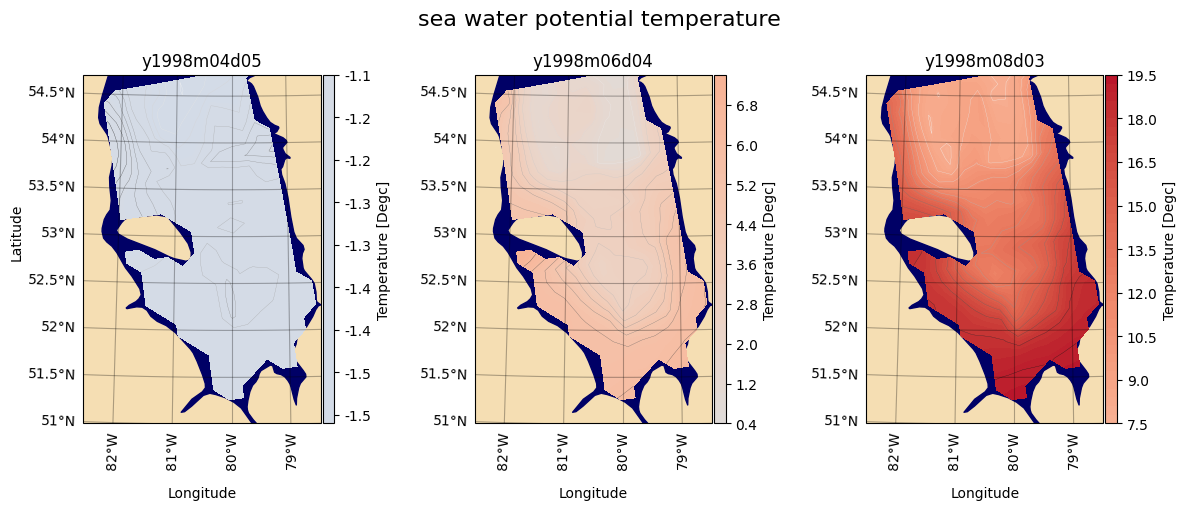

In [3]:
# Show maps for given location in list of files.
au.show_var_data_maps(file_list,lat_range,lon_range)

In order to look for MHWs, four parameters have been extracted from the region described above: mean, standard deviation, minimum and maximum SSTs. The extraction has been done on all currently available data which spans the years 1958 to 2009. 


In [4]:

# Load timeseries data
james_bay_timeseries_raw = pd.read_csv('../output_data/james_bay_timeseries_data.csv')

# Drop index column
james_bay_timeseries_raw.drop('Unnamed: 0',axis=1,inplace=True)

james_bay_timeseries = james_bay_timeseries_raw.copy()

# Chage date formating
james_bay_timeseries['date'] = pd.to_datetime(james_bay_timeseries['date'],format='%Y-%m-%d')

# Add Year column
james_bay_timeseries['year'] = james_bay_timeseries.date.dt.year

# Add Month column
james_bay_timeseries['month'] = james_bay_timeseries.date.dt.month

# Add day column
james_bay_timeseries['day'] = james_bay_timeseries.date.dt.day

# Add wrap-day column
#james_bay_timeseries['wrap_day'] = james_bay_timeseries.date.dt.strftime('%m-%d')

# # Change date formating
james_bay_timeseries['date2'] = james_bay_timeseries['date'].dt.date
james_bay_timeseries.drop('date',axis=1,inplace=True)
james_bay_timeseries.rename(columns={'date2':'date'},inplace=True)

# # Add wrap-day column
james_bay_timeseries['wrap_day'] = james_bay_timeseries.apply(lambda row: datetime.date(2000,row.month,row.day),axis=1)


The graph below shows these values corresponding to the maps above. 
Note that the rest of the analysis focuses on the mean values only. 

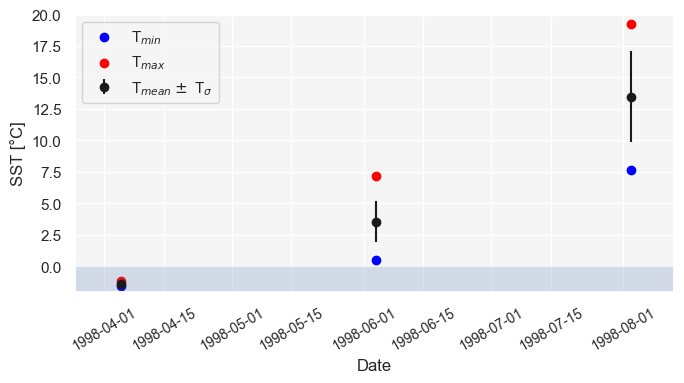

In [5]:
# Making list of dates from above maps
dates = [datetime.date(int(year),int(month),day_list[i]) for i,month in enumerate(month_list)]

# Selecting data given list of dates
james_bay_example = james_bay_timeseries[james_bay_timeseries['date'].isin(dates)]

# Setting up plot
sns.set(rc={'axes.facecolor':'whitesmoke'})
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

# Plotting data
plt.errorbar(james_bay_example['date'],james_bay_example['var_mean'],
             yerr=james_bay_example['var_std'],c='k',
             marker='o', linestyle='none', label= 'T$_{mean} \pm$ T$_{\sigma}$')
plt.scatter(james_bay_example['date'],james_bay_example['var_min'],c='blue', label= 'T$_{min}$')
plt.scatter(james_bay_example['date'],james_bay_example['var_max'],c='red', label= 'T$_{max}$')

# Set time limits
day_min = datetime.date(int(year),int(month_list[0])-1,day_list[0]+20)
day_max = datetime.date(int(year),int(month_list[-1]),day_list[-1]+10)

plt.ylim([-2,20])
plt.xlim([day_min,day_max])

# Plot frozen zone
plt.fill_between([day_min,day_max],[-2,-2],alpha=.2)

# Plot axis labels
plt.xlabel('Date',fontsize=12)
plt.ylabel('SST [\N{DEGREE SIGN}C]',fontsize=12)
plt.legend()

plt.tight_layout()

In [6]:
# Folding data yearly to get day stats.

james_bay_year_mean = james_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].mean().reset_index()
james_bay_year_median = james_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].median().reset_index()
james_bay_year_quantile = james_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].quantile(.9).reset_index()
james_bay_year_max = james_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].max().reset_index()



ANHA4 data has a five day resolution. Here, I show a 10 year range showing the seasonal distribution of the regional SSTs.


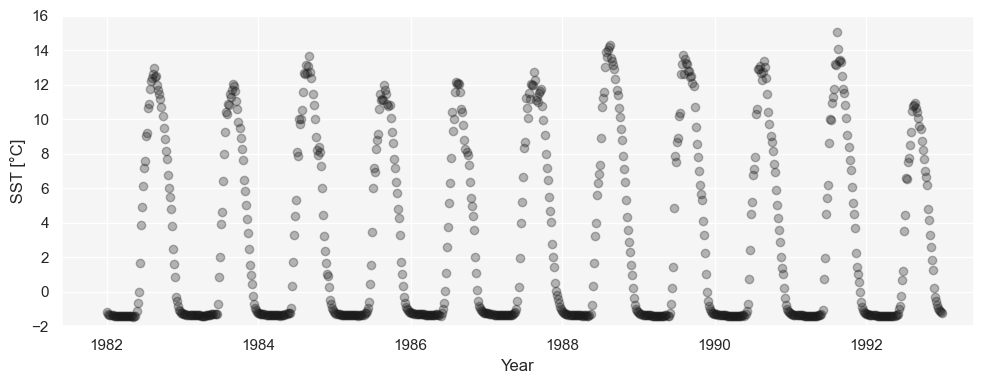

In [7]:

# Selecting data given year range
james_bay_timeseries_cut = james_bay_timeseries[(james_bay_timeseries['year'] > 1981) & (james_bay_timeseries['year'] < 1993)]

# Setting up plot
plt.figure(figsize=(10, 4))

# Plotting all data
plt.scatter(james_bay_timeseries_cut['date'],james_bay_timeseries_cut.var_mean,c='k',alpha=.3)

# Set time limits
day_min = datetime.date(1981,6,1)
day_max = datetime.date(1993,6,1)

plt.ylim([-2,16])
plt.xlim([day_min,day_max])

# Plot frozen zone
plt.fill_between([day_min,day_max],[-2,-2],y2=[-2,-2],alpha=.2)


plt.ylabel(' SST [\N{DEGREE SIGN}C] ')
plt.xlabel('Year')

plt.tight_layout()
plt.show()



The plot below was done by using the whole dataset climatology. It shows the mean SST, T$_{c}$, and the 90th percentile SST, T$_{90}$. Hobday et. al. (2008), uses their difference, $\Delta$T, to calculate the several MHW categories. Category I describes temperatures above T$_{90}$ (or T$_{c}$+ $\Delta$T). Categories II, III and IV are assigned for SST values above T$_{c}$+ 2$\Delta$T, T$_{c}$+ 3$\Delta$T, and T$_{c}$+ 4$\Delta$T, respectively. This plot also shows the maximum value, T$_{Max}$, for every given day present in the data. 

A couple of things are evident. The data contains Category I, II and even III events. There is also a peculiar SSTA in May 20th$^{*}$ that, if following the same definition it would be a Category VII, albeit the lower temperatures. This is mainly due to the earlier thawing, and thus a SST skewed towards freezing values which do not have much temperature variation making $\Delta$T particularly small. In terms of thawing times, for the extreme cases, the zero degree (SST$_{0}$) mark crosses about three weeks earlier than the average in the spring, and about two weeks later than average in the winter. The actual freezing point seems to be at about -1.3 C given the bay's salinity.  


$^{*}$The particular day is from 1998.


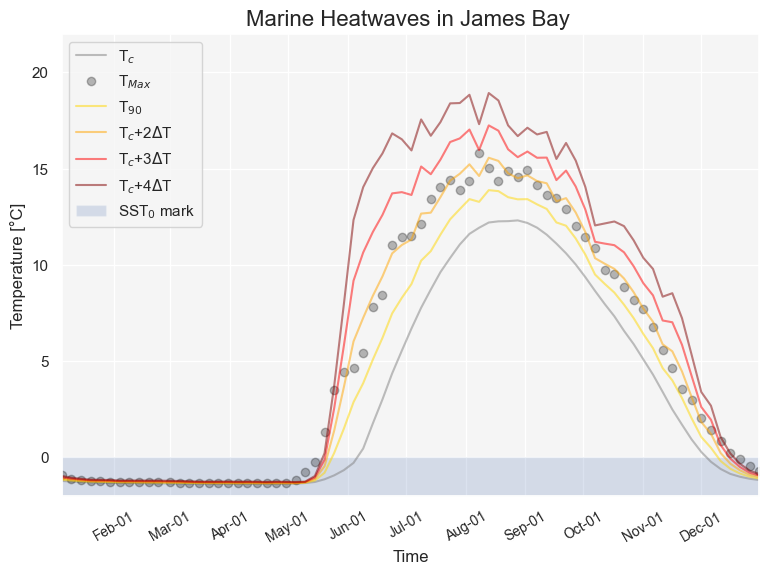

In [8]:
import matplotlib.dates as mdates

# Marine Heatwave plot. Using label sintax from Hobday et. al. 2018.


sns.set(rc={'axes.facecolor':'whitesmoke'})

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.plot(james_bay_year_mean['wrap_day'],james_bay_year_mean['var_mean'],c='gray',alpha=.5,label='T$_{c}$')
plt.plot(james_bay_year_max['wrap_day'],james_bay_year_max['var_mean'],'o',c='k',alpha=.3,label='T$_{Max}$')

#plt.plot(james_bay_year_median['wrap_day'],james_bay_year_median['var_mean'])
plt.plot(james_bay_year_quantile['wrap_day'],
         james_bay_year_quantile['var_mean'],
         c='gold',alpha=.5,label='T$_{90}$')
plt.plot(james_bay_year_quantile['wrap_day'],
         james_bay_year_mean['var_mean']+(james_bay_year_quantile['var_mean']-james_bay_year_mean['var_mean'])*2,
         c='orange',alpha=.5,label='T$_{c}$+2$\Delta$T')
plt.plot(james_bay_year_quantile['wrap_day'],
         james_bay_year_mean['var_mean']+(james_bay_year_quantile['var_mean']-james_bay_year_mean['var_mean'])*3,
         c='red',alpha=.5,label='T$_{c}$+3$\Delta$T')
plt.plot(james_bay_year_quantile['wrap_day'],
         james_bay_year_mean['var_mean']+(james_bay_year_quantile['var_mean']-james_bay_year_mean['var_mean'])*4,
         c='maroon',alpha=.5,label='T$_{c}$+4$\Delta$T')

# plt.plot(james_bay_year_quantile['wrap_day'],
#          james_bay_year_mean['var_mean']+(james_bay_year_quantile['var_mean']-james_bay_year_mean['var_mean'])*7,
#          c='k',alpha=.5,label='T$_{c}$+7$\Delta$T')



plt.fill_between([james_bay_year_mean['wrap_day'].iloc[0],james_bay_year_mean['wrap_day'].iloc[-1]],
                 [0,0],y2=[-2.,-2],alpha=.2,label='SST$_{0}$ mark')
# plt.fill_between([james_bay_year_mean['wrap_day'].iloc[0],james_bay_year_mean['wrap_day'].iloc[-1]],
#                  [-2,-2],y2=[-4.,-4],alpha=.4,facecolor='navy')


plt.ylim([-2,22])
plt.xlim([james_bay_year_mean['wrap_day'].iloc[0],james_bay_year_mean['wrap_day'].iloc[-1]])

plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=12)
plt.xlabel('Time',fontsize=12)
plt.title('Marine Heatwaves in James Bay ',fontsize=16)
plt.legend()


plt.show()


In [9]:
# Calculating time series MHW categories and merging them with the time series data itself.

james_bay_timeseries['var_mean_mean'] = np.array(james_bay_year_mean['var_mean'].to_list()*(2009-1958+1))
james_bay_timeseries['var_mean_quantile'] = np.array(james_bay_year_quantile['var_mean'].to_list()*(2009-1958+1))
james_bay_timeseries['var_mean_2T'] = james_bay_timeseries['var_mean_mean']+2*(james_bay_timeseries['var_mean_quantile']-james_bay_timeseries['var_mean_mean'])
james_bay_timeseries['var_mean_3T'] = james_bay_timeseries['var_mean_mean']+3*(james_bay_timeseries['var_mean_quantile']-james_bay_timeseries['var_mean_mean'])
james_bay_timeseries['var_mean_4T'] = james_bay_timeseries['var_mean_mean']+4*(james_bay_timeseries['var_mean_quantile']-james_bay_timeseries['var_mean_mean'])


To better analyze the MHWs, T$_{c}$ has been removed from the data. Showing the residual SST shown in the plot below. The highest deviations are seen for years 1998, 2001, 1999, and 2005, starting in order from the highest value. This interestingly coincides with Cree and Inuit accounts, and brings the follow up question to look at the whole Hudson Bay and check for MWH evolution there. 

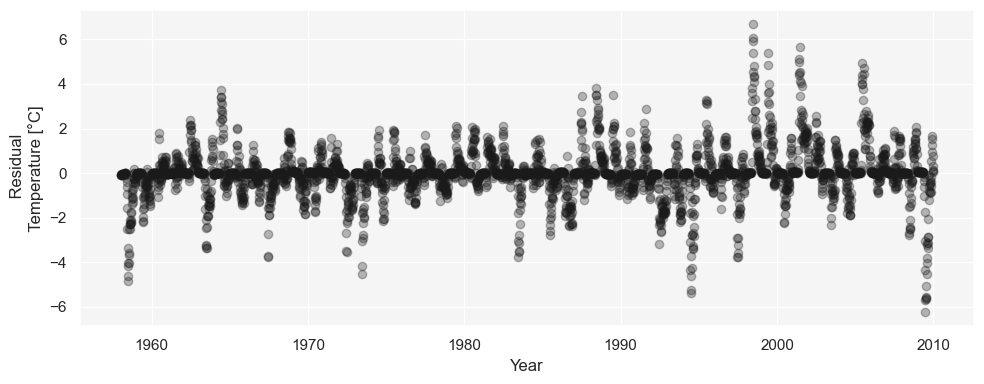

In [10]:
# Removing overal yearly mean to remove seasonal variability. 

plt.figure(figsize=(10, 4))

# Plotting all data
#plt.scatter(james_bay_timeseries['date'],james_bay_timeseries.var_mean,c=james_bay_timeseries.month,cmap='Greys')
plt.scatter(james_bay_timeseries['date'],james_bay_timeseries.var_mean-james_bay_timeseries.var_mean_mean,c='k',alpha=.3)

#max_years = pd.DataFrame([datetime.date(1998,6,1),datetime.date(1999,6,1),datetime.date(2001,6,1),datetime.date(2005,6,1)])
# plt.vlines(max_years, np.array([-6]*4),np.array([6]*4))

plt.ylabel(' Residual\n Temperature [\N{DEGREE SIGN}C] ')
plt.xlabel('Year')

plt.tight_layout()
plt.show()


# The years with the highest positive varibility are: 1998,2001,1999,2005. 
# In that order, based on the single maximum value.


These four years are shown below. All but 1999 present Category II events lasting for a few days, and Category I events lasting for a month or two.  Year 1999 contains Category I events lasting a couple of weeks, with the peak residual SST of 5.4 $^{o}$C (June 14th), making it the year with the 3rd highest. The highest peak residual SST in the model is shown for 1998 at 6.7 $^{o}$C (June 24th).



In [11]:

def plot_year_mhw(james_bay_timeseries,year=1998,remove_mean=True,show_cat4=False,region="James Bay"):
    """    """
    
    # Selecting year from timeseries
    james_bay_timeseries_year = james_bay_timeseries[james_bay_timeseries['year'] == year].copy()

    if remove_mean:
        labels = ['SST - T$_{c}$','$\Delta$T','2$\Delta$T','3$\Delta$T','4$\Delta$T']
        
        # Get freezing line
        freezing_line = james_bay_timeseries_year['var_mean_mean']*-1
        # Removing the yealy average T$_{c}$
        james_bay_timeseries_year['var_mean'] = james_bay_timeseries_year.apply(lambda row: row.var_mean - row.var_mean_mean,axis=1)
        james_bay_timeseries_year['var_mean_quantile'] = james_bay_timeseries_year.apply(lambda row: row.var_mean_quantile - row.var_mean_mean,axis=1)
        james_bay_timeseries_year['var_mean_2T'] = james_bay_timeseries_year.apply(lambda row: row.var_mean_2T - row.var_mean_mean,axis=1)
        james_bay_timeseries_year['var_mean_3T'] = james_bay_timeseries_year.apply(lambda row: row.var_mean_3T - row.var_mean_mean,axis=1)
        james_bay_timeseries_year['var_mean_4T'] = james_bay_timeseries_year.apply(lambda row: row.var_mean_4T - row.var_mean_mean,axis=1)
        
    else:
        labels = ['SST','T$_{90}$','T$_{c}$+2$\Delta$T','T$_{c}$+3$\Delta$T','T$_{c}$+4$\Delta$T']
        
    # Setting up figure
    plt.figure(figsize=(9, 5))

    # Plotting all data

    if not remove_mean:
        plt.plot(james_bay_timeseries['date'],
                 james_bay_timeseries.var_mean_mean,
                 c='gray',alpha=.5,label='T$_{c}$')
        
    plt.scatter(james_bay_timeseries_year['date'],
                james_bay_timeseries_year.var_mean,
                c='k',alpha=.3,label=labels[0])

    plt.plot(james_bay_timeseries_year['date'],
             james_bay_timeseries_year.var_mean_quantile,
             c='gold',alpha=.3,label=labels[1])
    plt.plot(james_bay_timeseries_year['date'],
             james_bay_timeseries_year.var_mean_2T,
             c='orange',alpha=.3,label=labels[2])
    plt.plot(james_bay_timeseries_year['date'],
             james_bay_timeseries_year.var_mean_3T,
             c='red',alpha=.3,label=labels[3])
    if show_cat4:
        plt.plot(james_bay_timeseries_year['date'],
                 james_bay_timeseries_year.var_mean_4T,
                 c='maroon',alpha=.3,label=labels[4])

    # Fill in categories colors
    plt.fill_between(james_bay_timeseries_year['date'],
                     james_bay_timeseries_year.var_mean_quantile,
                     y2=james_bay_timeseries_year.var_mean_2T,
                     alpha=.1,facecolor='gold')

    plt.fill_between(james_bay_timeseries_year['date'],
                     james_bay_timeseries_year.var_mean_2T,
                     y2=james_bay_timeseries_year.var_mean_3T,
                     alpha=.1,facecolor='orange')

    if show_cat4:
        plt.fill_between(james_bay_timeseries_year['date'],
                         james_bay_timeseries_year.var_mean_3T,
                         y2=james_bay_timeseries_year.var_mean_4T,
                         alpha=.1,facecolor='red')    

    if remove_mean:
        plt.fill_between(james_bay_timeseries_year['date'],freezing_line,alpha=.3,label='SST$_{0}$ mark')
        
    else:
        plt.fill_between(james_bay_timeseries_year['date'],james_bay_timeseries_year['var_mean']*0.-2.,alpha=.3,label='Freezing line')

    # Set axis limits and labels
    if remove_mean:
        plt.ylim(bottom=0)
    else:
        plt.ylim(bottom=-2)        
    plt.xlim([james_bay_timeseries_year['date'].iloc[0],james_bay_timeseries_year['date'].iloc[-1]])
    plt.ylabel(' Residual\n Temperature [\N{DEGREE SIGN}C]',fontsize=12)
    plt.xlabel('Year',fontsize=12)
    plt.title('%s %i MHW'%(region,year),fontsize=16)
    plt.legend()

    plt.tight_layout()
    plt.show()
    

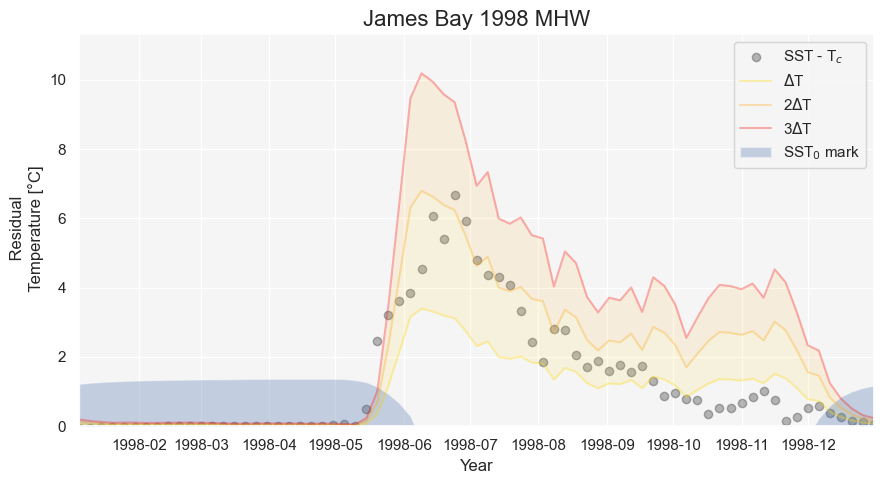

In [12]:
# MHW 1998

year = 1998 

plot_year_mhw(james_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


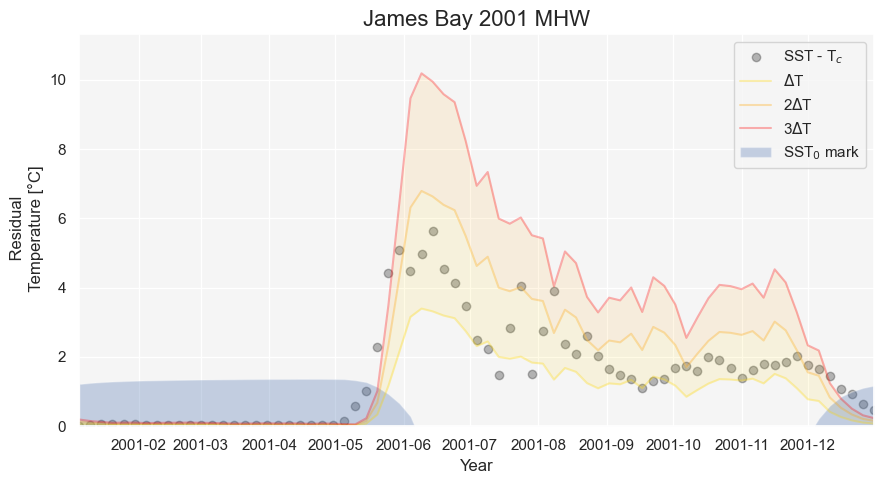

In [13]:
# MHW 

year = 2001 

plot_year_mhw(james_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


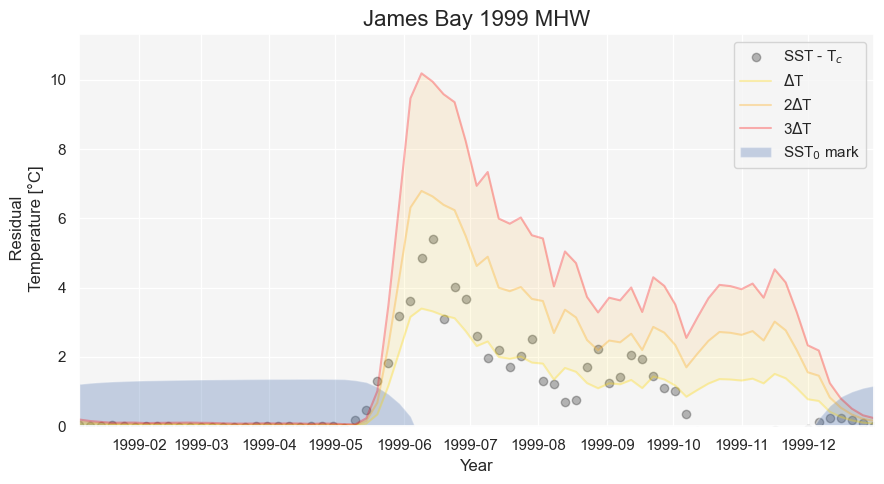

In [14]:
# MHW 

year = 1999 

plot_year_mhw(james_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


<IPython.core.display.Javascript object>


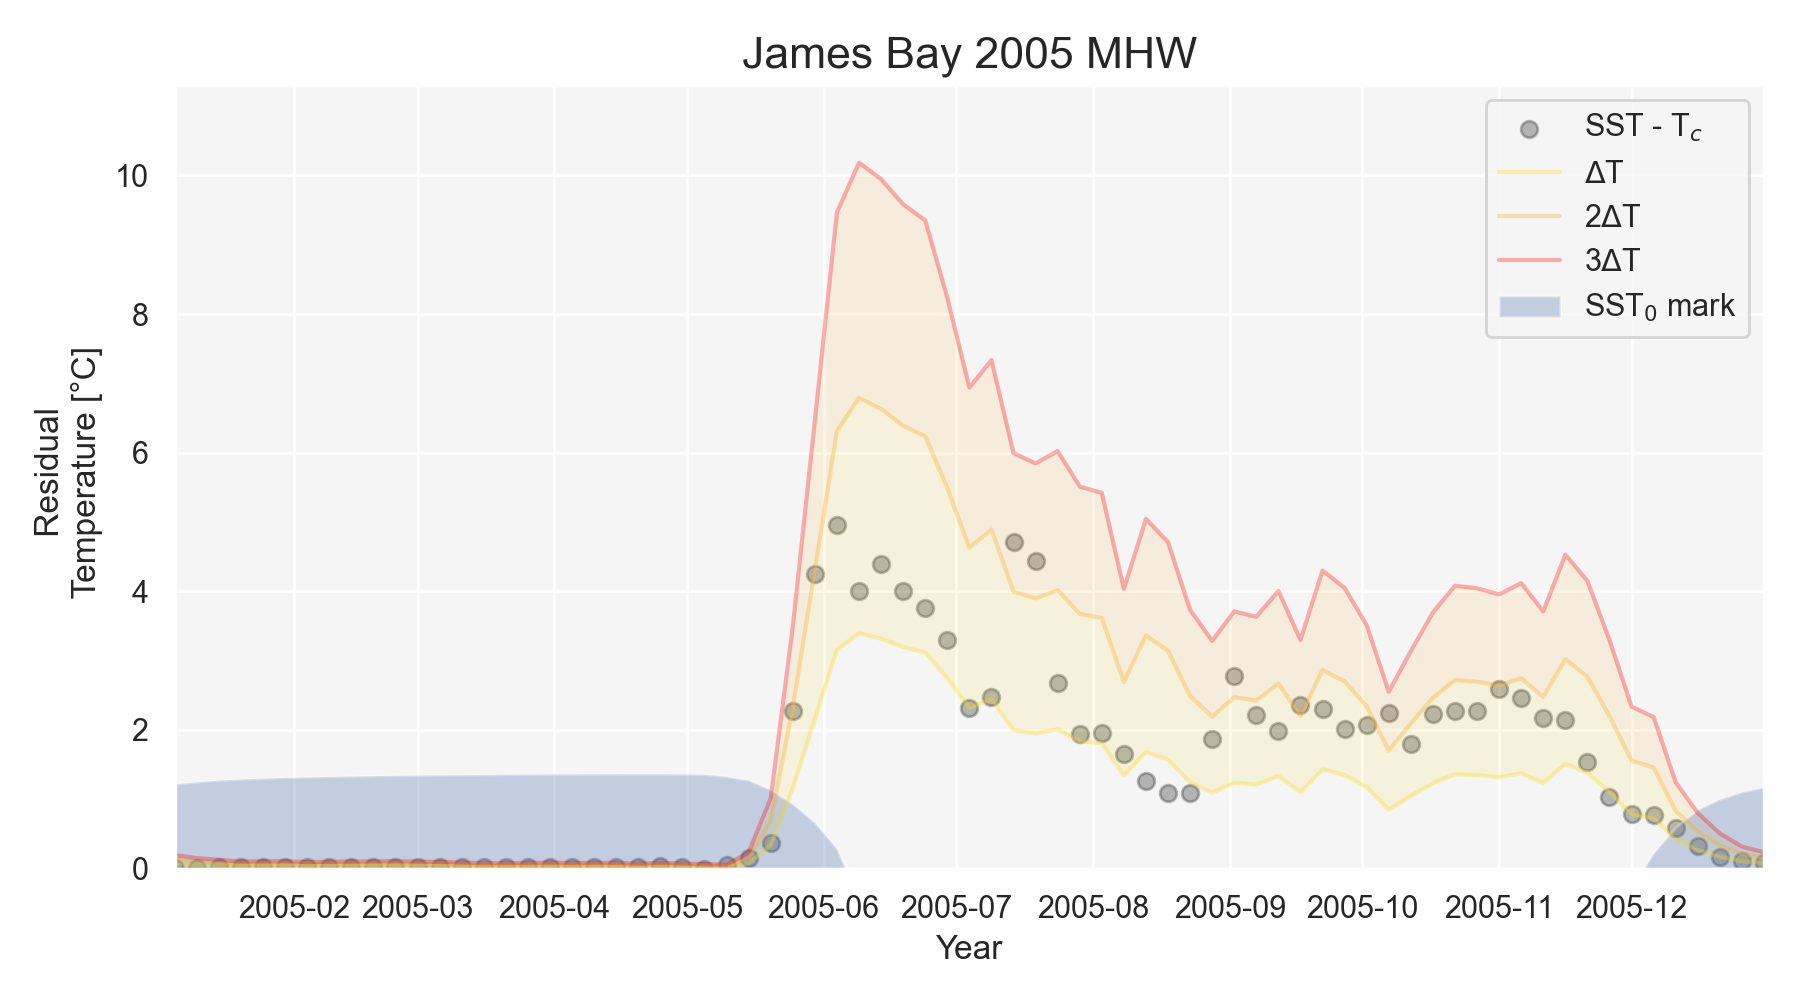

In [18]:
# MHW 

year = 2005 

plot_year_mhw(james_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


-----